In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import cdist_dtw, dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation

from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

import get_time_series 

# Preprocessing

In [ ]:
year_data = 'Twitter15'
dest = 'tw15'

t = os.path.join('gdrive/My Drive/Master/Data', year_data, 'tree.tar.gz')
p = os.path.join('gdrive/My Drive/Master/Data', year_data, 'post.tar.gz')
u = os.path.join('gdrive/My Drive/Master/Data', year_data, 'users.tar.gz')
l = os.path.join('gdrive/My Drive/Master/Data', year_data, 'label.txt')

!mkdir "$dest"
!tar -xzvf "$t" -C "$dest"
!tar -xzvf "$p" -C "$dest"
!tar -xzvf "$u" -C "$dest"
!cp "$l" "$dest"

In [ ]:
class data_process:
    def __init__(self, path = './'):
        self.news = get_time_series.load_data(path = path)
        self.posts = get_time_series.load_data_posts(path = path)
        self.users = get_time_series.load_data_users(path = path)

In [ ]:
%%time
dest = 'tw15'
data = data_process(dest)

CPU times: user 47.4 s, sys: 7.21 s, total: 54.6 s
Wall time: 55.1 s


In [ ]:
%%time
window = 10
sliding_window = True 
time = 720
labels, followers = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followers', window, sliding_window, time)
labels, following = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'followings', window, sliding_window, time)
labels, new_users = get_time_series.get_fingerprints(data.news, data.users, data.posts, 'new_users', window, sliding_window, time)
print(labels.shape)
print(followers.shape)
print(following.shape)
print(new_users.shape)

In [ ]:
%%time
labels, retweets, posts = get_time_series.get_interactions(data.news, 10, True, 720)
print(labels.shape)
print(retweets.shape)
print(posts.shape)

(818,)
(818, 720)
(818, 720)


In [ ]:
def get_multivariate_series(time_series, labels, scale = 1): 
        paa = PiecewiseAggregateApproximation(n_segments=140) # equals the number of segments and samples!!!
        digits = []
        for i in range(72):
            digits.append(i*10)
        digits = np.array(digits)
        
        if scale == 0:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                # scaler = StandardScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                time_series_scaled.append(ts)
        elif scale == 1:
            time_series_scaled = []
            for ts in time_series:
                scaler = MinMaxScaler()
                # scaler = StandardScaler()
                scaler.fit(ts)
                ts = scaler.transform(ts)
                # print('1 ', ts.shape)
                ts = ts.reshape(ts.shape[0], ts.shape[1], 1)
                ts = paa.inverse_transform(paa.fit_transform(ts))
                # print(ts.shape)
                ts = ts[:,digits,:]
                # print(ts.shape)
                ts = ts.reshape(ts.shape[0],ts.shape[1])
                # print(ts.shape)
                time_series_scaled.append(ts) 
        elif scale == 2:  
            time_series_scaled = []
            for ts in time_series:  
                time_series_scaled.append(ts)
        time_series_multi = np.stack(time_series_scaled, axis=-1) # -1
        return time_series_multi

In [ ]:
time_series = get_multivariate_series(time_series=[retweets, posts, interactions, followers, following, new_users], 
                                      labels=labels, scale=1)
x_train, x_test, y_train, y_test = train_test_split(time_series, labels, test_size=0.2, stratify=labels)

In [ ]:
print(time_series.shape)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(818, 72, 18)
(654, 72, 18)
(654,)
(164, 72, 18)
(164,)


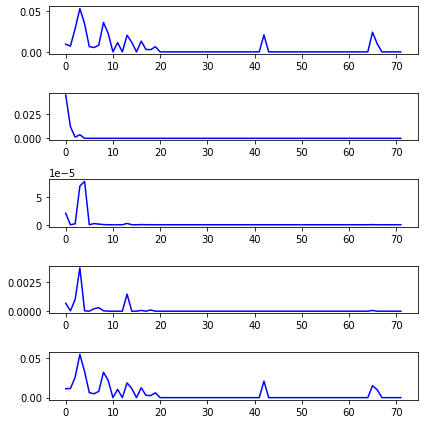

In [ ]:
i = 10
plt.rcParams["figure.figsize"] = (6,6)
plt.figure()
plt.subplot(5,1,1)
plt.plot(time_series[i,:,0].ravel(), "b-") #retweets
plt.subplot(5,1,2)
plt.plot(time_series[i,:,1].ravel(), "b-") #posts
plt.subplot(5,1,3)
plt.plot(time_series[i,:,2].ravel(), "b-") #followers
plt.subplot(5,1,4)
plt.plot(time_series[i,:,3].ravel(), "b-") #following
plt.subplot(5,1,5)
plt.plot(time_series[i,:,4].ravel(), "b-") #new_users
plt.tight_layout()
plt.show()

# Clustering - get prototypes

In [ ]:
def confusion_matrix(y_train, y_clus, n_prototypes):
    n_classes = np.unique(y_train).shape[0]
    conf = np.zeros((n_classes,n_prototypes), dtype=int)
    n_instances = y_clus.shape[0]
    for k in range(n_instances):
        i = y_train[k]
        j = y_clus[k]
        conf[i][j] += 1 
    return conf

def gini_coefficient(conf):
    n_classes = conf.shape[0]
    n_prototypes = conf.shape[1]
    gini = np.zeros(n_prototypes, dtype=float)
    for j in range(n_prototypes):
        acc = float(conf[:,j].sum())
        if acc > 0:
            for i in range(n_classes):
                ratio = float(conf[i,j])/acc #la proporción del cluster que fue asignado a esa clase
                gini[j] += pow(ratio, 2)
            gini[j] = round(1 - gini[j], 3)
        else:
            gini[j] = np.nan
    return gini
    
def matprint(mat, fmt="g"): #print confusion matrix
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T] 
    # print(col_maxes)
    for x in mat:
        # print(x)
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [ ]:
def get_h_clus_(filepath):
    h_clus_ = []
    # filepath = 'tw16.hgr.part.40' #archivo del profe
    with open(filepath) as fp: 
        cix = fp.readline().rstrip('\n')
        h_clus_.append(int(cix))
        while cix:
            cix = fp.readline().rstrip('\n')
            if len(cix) > 0:
                h_clus_.append(int(cix))
    return np.array(h_clus_)

In [ ]:
h_clus_50 = get_h_clus_('tw16_50.hgr.part.50')
h_clus_50.shape

(654,)

In [ ]:
conf_50 = confusion_matrix(y_train,h_clus_50,50)
matprint(conf_50)

5  4  9  2  3  4  5  6  3  3  3  3  0  4  1  3  3  3  1  1  3  2  2  3  1  3  3  3  5  3  1  8  5  0  1  4  4  3  4  4  1  3  4  4  6  5  3  3  4  4  
2  1  3  6  1  7  1  3  3  2  4  2  7  4  2  6  2  7  2  1  3  7  4  6  2  3  2  4  3  0  7  0  3  7  1  5  5  4  7  3  1  3  3  1  1  3  4  5  0  1  
5  6  1  3  4  1  3  2  3  4  4  5  3  4  6  1  5  1  6  6  6  1  3  0  5  3  3  1  2  3  3  2  1  3  5  2  3  3  1  4  6  3  2  3  2  3  3  0  7  5  
2  3  1  3  5  1  4  2  4  4  2  3  3  1  4  3  3  2  4  5  1  3  4  4  5  4  5  5  3  7  2  3  4  3  6  2  1  3  1  2  5  4  4  5  4  2  3  5  2  3  


In [ ]:
gini_50 = gini_coefficient(conf_50)
print(sum(gini_50)/50)

0.67694


In [ ]:
def get_cidx_(conf_):
    cidx_ = dict()
    for j in range(conf_.shape[1]):
        cl = np.argmax(conf_[:,j])
        cidx_[j] = cl  #Clase (0,1,2,3) a la que pertece cada cluster
    return cidx_

In [ ]:
cidx_50 = get_cidx_(conf_50)

In [ ]:
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.metrics import dtw

def ba_computing(h_clus_,x_train,cidx_): #h_clus_: Cluster al que pertece cada noticia, cidx_: Clase (0,1,2,3) a la que pertece cada cluster
    n_instances = h_clus_.shape[0]
    n_prototypes = len(np.unique(h_clus_)) #40 por ejemplo
    prototypes = []
    for i in range(n_prototypes):
        digits = np.where(h_clus_ == i)[0] #ids de noticias de ese cluster
        cls = cidx_[i] # clase del cluster
        x_ = x_train[digits,:,:] #datos agrupados en el i-ésimo cluster 
        y_ = y_train[digits]
        digits_ = np.where(y_ == cls)[0] #ids de datos en que coincide la clase real y la del cluster
        ba = dtw_barycenter_averaging(x_[digits_,:,:]) #obtener el prototipo
        prototypes.append(ba) 
    return np.array(prototypes)

In [ ]:
prototypes_50 = ba_computing(h_clus_50,x_train,cidx_50)
print(prototypes_50.shape)

(50, 72, 9)


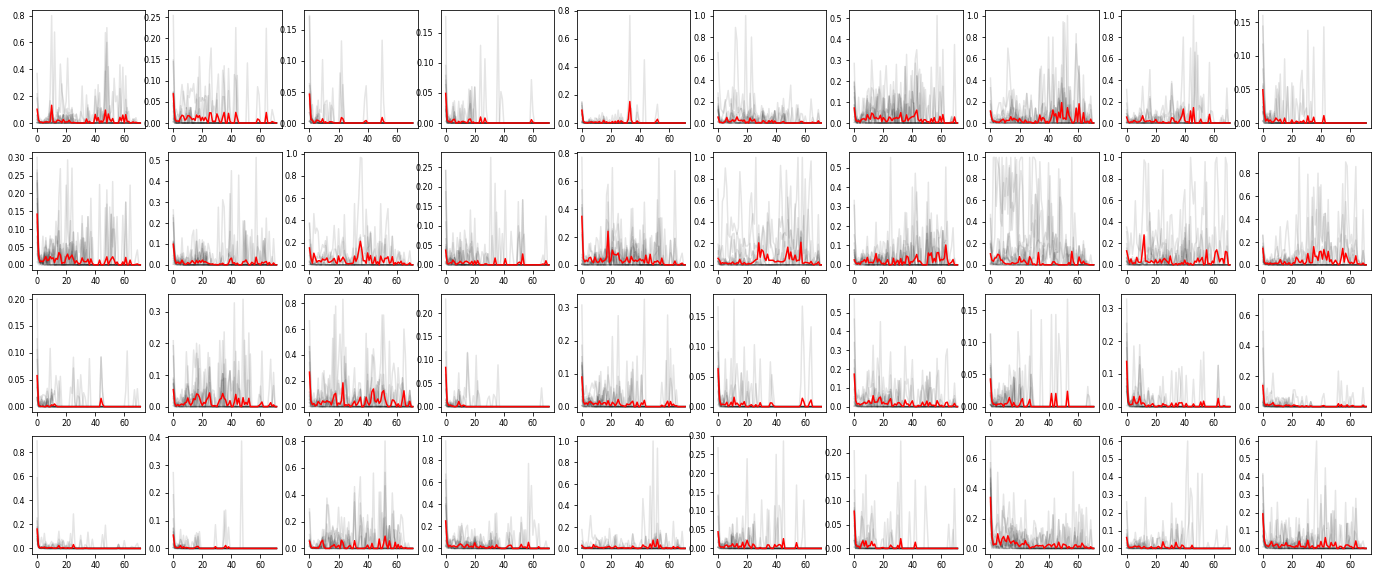

In [ ]:
prototypes = prototypes_40
h_clus = h_clus_40
plt.rcParams["figure.figsize"] = (24,10)
plt.rcParams.update({'font.size': 8})
plt.figure()
for i in range(len(prototypes)):
        plt.subplot(4, 10, i+1)
        for xx in x_train[h_clus == i]:
            plt.plot(xx[:,1].ravel(), "k-", alpha=.1)
            #plt.ylim(0,1)
        plt.plot(prototypes[i][:,1].ravel(), "r-")

# Siamese network

In [ ]:
from random import randint

def unassigned(x,y,prototypes,cidx):
    max_dis = np.inf
    arg_min = 0
    for pid in cidx.keys():  #revisar cada cluster
        cl = cidx[pid]      #clase del cluster
        if cl == y:         #encontrar coincidencia de la clase del cluster con la clase real
            p = prototypes[pid]     #prototipo del cluster
            dis = dtw(x,p) 
            if dis < max_dis:
                arg_min = pid
                max_dis = dis
    return arg_min  #id del prototipo con distancia minima a la instancia x

def create_pairs(x, y, prototypes, h_clus, cidx):
        pairs = [] 
        labels = []
        n_classes = np.unique(y).shape[0]
        n_prototypes = prototypes.shape[0] 
        n_instances = x.shape[0]
        for i in range(n_instances):
            pid = h_clus[i]   #cluster al que pertenece la instancia
            cl_pr = cidx[pid]  #clase a la que pertenece el cluster de la instancia  --> clase prototipo
            cl_gr = y[i]        #ground truth
            if cl_pr != cl_gr:
                pid = unassigned(x[i], cl_gr, prototypes, cidx)
            p = prototypes[pid]
            for pix in np.delete(np.arange(n_prototypes), pid):
                if cidx[pix] != cl_gr:
                    _p = prototypes[pix]
                    pairs += [[x[i], p]]
                    labels += [0]
                    pairs += [[x[i], _p]]
                    labels += [1]         
        pairs, labels = shuffle(np.array(pairs), np.array(labels), random_state=0)
        return pairs, labels 

In [ ]:
tr_pairs_50, tr_y_50 =  create_pairs(x_train, y_train, prototypes_50, h_clus_50, cidx_50)
print(tr_pairs_50.shape, tr_y_50.shape)

(49048, 2, 72, 9) (49048,)


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda, Activation, LSTM, Conv1D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta
from tensorflow.keras.metrics import BinaryAccuracy, CosineSimilarity, Accuracy, categorical_accuracy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model, to_categorical 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

import tensorflow_addons as tfa
from tensorflow_addons.losses import contrastive_loss
from tensorflow_addons.metrics import F1Score

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true) * square_pred + (y_true) * margin_square)

def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.1)(x)
    return Model(input, x)
    
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred != y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
tr_y_50 = tf.cast(tr_y_50, dtype='float32')

In [ ]:
input_shape = tr_pairs_50.shape[2:]
base_network = create_base_network(input_shape)
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
model_50 = Model([input_a, input_b], distance)
rms = RMSprop(learning_rate=0.0001)
model_50.compile(loss=contrastive_loss, optimizer=rms)
history_50 = model_50.fit([tr_pairs_50[:, 0], tr_pairs_50[:, 1]], tr_y_50, batch_size=64, epochs=50, validation_split=0.3, verbose=False)

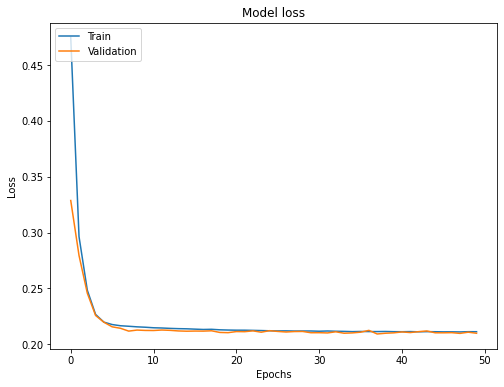

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.plot(history_50.history['loss'])
plt.plot(history_50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
# plt.ylim(0,1.0)
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model_50.predict([tr_pairs_50[:,0],tr_pairs_50[:,1]])
print(compute_accuracy(tr_y_50, y_pred))

0.6707714891534823


In [ ]:
def get_instance(x_ins, prototypes, model_):
    n_prototypes = prototypes.shape[0]
    outcomes = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        x_test_pair = np.empty([0, 2, x_ins.shape[0], x_ins.shape[1]])
        pair = np.array([[x_ins, prototypes[i]]])
        x_test_pair = np.append(x_test_pair, pair, axis=0)
        outcomes[i] = model_.predict([x_test_pair[:, 0], x_test_pair[:, 1]])
    return outcomes

def get_bias(x_train,prototypes,model_):
    n_prototypes = prototypes.shape[0]
    n_instances = x_train.shape[0]
    outcomes = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes[i,:] = get_instance(x_train[i],prototypes,model_)
    
    means = np.arange(n_prototypes, dtype=float)
    desvs = np.arange(n_prototypes, dtype=float)
    for i in range(n_prototypes):
        means[i] = np.mean(outcomes[:,i])
        desvs[i] = np.std(outcomes[:,i])
    return means, desvs, outcomes

def get_unbias(outcomes, means):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        outcomes_[i,:] = outcomes[i,:] - means
    return outcomes_

In [ ]:
means_tr_10, desvs_tr_10, outcomes_tr_10 = get_bias(x_train,prototypes_10,model_10)
means_te_10, desvs_te_10, outcomes_te_10 = get_bias(x_test,prototypes_10,model_10)
outcomes_tr_un_10 = get_unbias(outcomes_tr_10,means_tr_10)
outcomes_te_un_10 = get_unbias(outcomes_te_10,means_tr_10)
print(means_tr_10.shape, desvs_tr_10.shape, outcomes_tr_10.shape)
print(means_te_10.shape, desvs_te_10.shape, outcomes_te_10.shape)
print(outcomes_tr_un_10.shape, outcomes_te_un_10.shape)

In [ ]:
%%time
means_tr_50, desvs_tr_50, outcomes_tr_50 = get_bias(x_train,prototypes_50,model_50)
means_te_50, desvs_te_50, outcomes_te_50 = get_bias(x_test,prototypes_50,model_50)
outcomes_tr_un_50 = get_unbias(outcomes_tr_50,means_tr_50)
outcomes_te_un_50 = get_unbias(outcomes_te_50,means_tr_50)
print(means_tr_50.shape, desvs_tr_50.shape, outcomes_tr_50.shape)
print(means_te_50.shape, desvs_te_50.shape, outcomes_te_50.shape)
print(outcomes_tr_un_50.shape, outcomes_te_un_50.shape)

(50,) (50,) (654, 50)
(50,) (50,) (164, 50)
(654, 50) (164, 50)
CPU times: user 26min 22s, sys: 27 s, total: 26min 49s
Wall time: 26min 34s


# Bias and variance modeling

In [ ]:
def eval_instance(i,outcomes,y,cidx_,verbose=False):
    if verbose: 
        print("GT:",y[i])
        print("PR:",cidx_[np.argmin(outcomes[i,:])], np.argmin(outcomes[i,:]))
        print(y[i] == cidx_[np.argmin(outcomes[i,:])])
        print(outcomes[i,])
    return y[i] == cidx_[np.argmin(outcomes[i,:])]

def get_accuracy(outcomes,y,cidx_):
    accum = 0
    n_instances = outcomes.shape[0]
    for i in range(n_instances):
        val = eval_instance(i,outcomes,y,cidx_)
        if (val == True): accum += 1
    return accum/n_instances

In [ ]:
print(get_accuracy(outcomes_tr_un_50,y_train,cidx_50))
print(get_accuracy(outcomes_te_un_50,y_test,cidx_50))

0.46788990825688076
0.4451219512195122


# MLP (tomo las salidas de la Siamesa para entrenar el MLP)

In [ ]:
def get_ml_set(outcomes):
    n_instances = outcomes.shape[0]
    n_prototypes = outcomes.shape[1]
    outcomes_ = np.arange(n_instances*n_prototypes, dtype=float).reshape(n_instances,n_prototypes)
    for i in range(n_instances):
        xls = outcomes[i,:]*-1   #Cambiar sentido de la distancia, mientras más cerca mejor
        xls = xls - np.min(xls)
        xls = xls/np.max(xls)
        outcomes_[i,:] = xls    # resultados normalizado
    return outcomes_

In [ ]:
outcomes_training_50 = get_ml_set(outcomes_tr_50)
outcomes_testing_50 = get_ml_set(outcomes_te_50)

In [ ]:
print(outcomes_training_40.shape)
print(outcomes_testing_40.shape)
print(y_train.shape)

(654, 40)
(164, 40)
(654,)


In [ ]:
from sklearn.neural_network import MLPClassifier

clf_50 = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(32,4), random_state=1, validation_fraction=0.5, verbose=False, max_iter=1000)
clf_50.fit(outcomes_training_50,y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 4), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.5, verbose=False,
              warm_start=False)

In [ ]:
print(clf_50.score(outcomes_training_50,y_train))
print(clf_50.score(outcomes_testing_50,y_test))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average='macro'))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average='macro'))
print()
print(f1_score(clf_50.predict(outcomes_training_50),y_train, average=None))
print(f1_score(clf_50.predict(outcomes_testing_50),y_test, average=None))

0.5244648318042814
0.5121951219512195

0.5155982725932167
0.4996152574050594

[0.63829787 0.62765957 0.44       0.35643564]
[0.58974359 0.63366337 0.47368421 0.30136986]
